In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/index-data/Index2018.csv


In [2]:
import warnings
warnings.simplefilter('ignore')

# Loading necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [4]:
data = pd.read_csv('/kaggle/input/index-data/Index2018.csv')
d1 = pd.DataFrame(data)
d1[:2]

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44


In [5]:
data1 = d1.copy()
data1.date = pd.to_datetime(d1.date, dayfirst=True) #setting the date variable dtype as date in order yyyy-mm-dd
data1.set_index('date',inplace=True)
data1 = data1.asfreq('b')
data1.fillna(method='ffill', inplace=True) #ffill = forward fill = filling ahead the null values

# Data Exploration and Preprocessing

In [6]:
data1.shape

(6277, 4)

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6277 entries, 1994-01-07 to 2018-01-29
Freq: B
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6277 non-null   float64
 1   dax     6277 non-null   float64
 2   ftse    6277 non-null   float64
 3   nikkei  6277 non-null   float64
dtypes: float64(4)
memory usage: 245.2 KB


In [8]:
data1.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [9]:
data1.describe()

,spx,dax,ftse,nikkei
count,6277.000000,6277.000000,6277.000000,6277.000000
mean,1288.642547,6083.381061,5423.679824,14597.672753
std,487.868210,2755.563853,1145.616719,4043.795272
min,438.920000,1911.700000,2876.600000,7054.980000
25%,992.715221,4070.460000,4486.730000,10701.130000
50%,1233.761241,5774.260000,5663.300000,15030.510000
75%,1460.250000,7445.560000,6304.630175,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [10]:
data1.head(2)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44


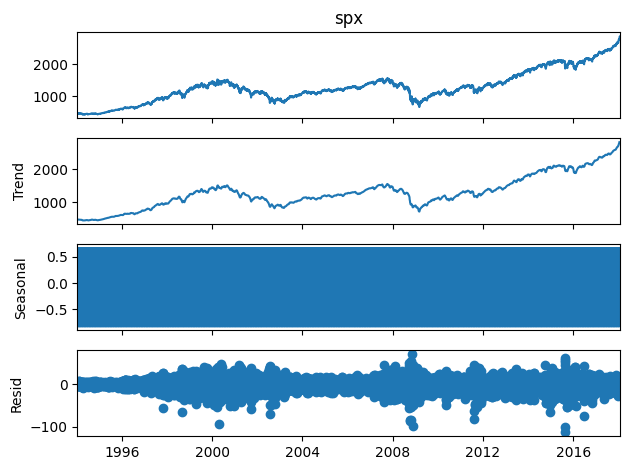

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(data1['spx'], period=12).plot() #period: how many times calculated in a year (12=monthly, 4=quarterly, 1=annual)

- trend exists - upward movement
- seasonality (seasonal variations at regular time intervals) exists
- not cyclicity(seasonal variations at irregular time intervals)

we can observe trend and seasonality clearly - hence, data is non-stationary

# Checking for Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller 
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


* checks for stationarity by checking if autocorrelation between values exists or notstationary
* no autocorrelation
* we see trend here so not stationary
* null hypothesis - non-stationary
* kpss test


In [13]:
series = data1['spx']

In [14]:
output = adfuller(series) #can use adf_test function instead of adfuller
output

(1.11949863817284,
 0.9953796476080692,
 10,
 6266,
 {'1%': -3.4313940441948807,
  '5%': -2.8620013751563964,
  '10%': -2.567015587023998},
 50258.209867750025)

* the second value in the tuple is the p-value(0.99), which must be less than 0.05 for null to be rejected
* the first value is the t-statistic(1.119), which should be greater than the value at significance level (here, 5% = -2.88) for the null to be rejected
* hence, we cannot reject the null
* interpretation: series is non-stationary
* hence, we will do differencing

# Differencing 1

In [15]:
diff_series = series.diff() #for differenecing the series
diff_series[:2]

date
1994-01-07     NaN
1994-01-10    5.37
Freq: B, Name: spx, dtype: float64

the first value will always be null

In [16]:
diff_series1 = pd.DataFrame(diff_series).dropna()
diff_series1[:2]

,spx
date,
1994-01-10,5.37
1994-01-11,-1.14


* now we check if we need to differentiate more or not by hypothesis testing using adfuller
* if still stationary, differentiate again


In [17]:
output_after_diff1 = adf_test(diff_series1['spx'])
output_after_diff1

Results of Dickey-Fuller Test:
Test Statistic                -1.416837e+01
p-value                        2.023543e-26
#Lags Used                     3.400000e+01
Number of Observations Used    6.241000e+03
Critical Value (1%)           -3.431398e+00
Critical Value (5%)           -2.862003e+00
Critical Value (10%)          -2.567017e+00
dtype: float64


<Axes: xlabel='date'>

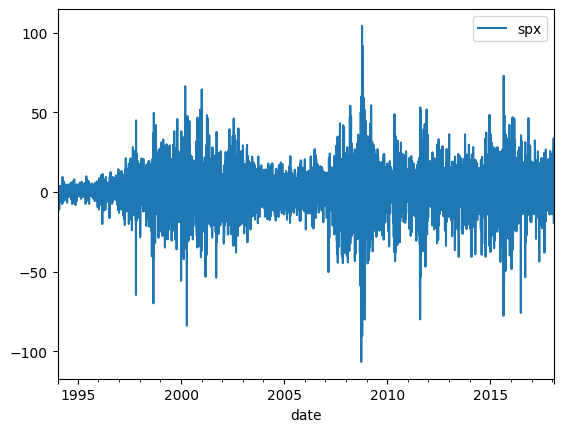

In [18]:
diff_series1.plot()

* the p-value is less than 0.05, hence we can now reject the null
* now the series (diff_series1) is stationary and can be used for ARIMA

# KPSS test for Stationarity
* null hypothesis: stationary

In [19]:
from statsmodels.tsa.stattools import kpss
output = kpss(series)
output

<ipython-input-19-ee4bb9879454>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  output = kpss(series)


(8.680408363867764,
 0.01,
 46,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

* the p-value is less than 0.05
* moreover, as the warning suggests, the p-value is extremely small
* hence, we can reject the null hypothesis
* interpretation: non-stationary

In [20]:
output_after_diff1 = kpss(diff_series1['spx'])
output_after_diff1

<ipython-input-20-80975a28bee6>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  output_after_diff1 = kpss(diff_series1['spx'])


(0.3449491335137664,
 0.1,
 21,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

* now the p-value is greater than 0.05, hence we can not reject the null
* the warning suggests that the actual p-value is even greater, hence re-iterating insufficiency of evidence to reject null hypothesis
* interpretation: we do not have enough evidence to suggest that the series is not stationary

# ACF to get the value of Q

we will check which values lie most outside the significance level (which values contribute the most)

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

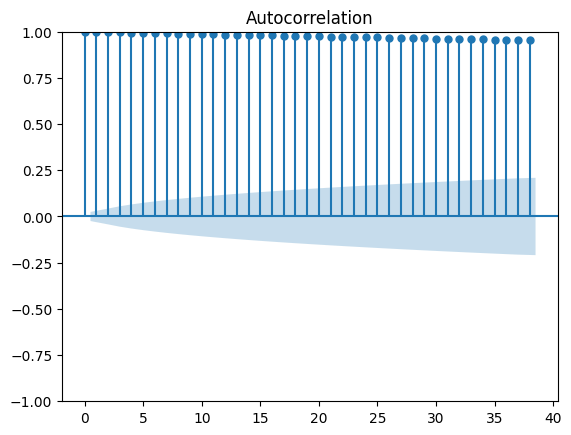

In [22]:
plt = plot_acf(series)
plt.show()

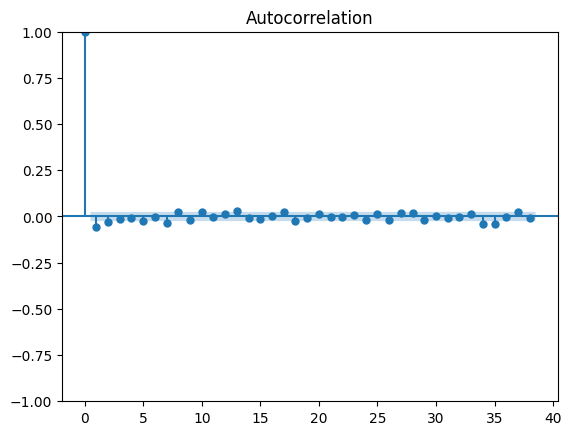

In [23]:
plt = plot_acf(diff_series1['spx'])
plt.show()

* 4 values lie outside the significance level
* these are the significant lags to be used for time series = Q variable in arima
* so we can maximum use 4 lags (Q=4), but starting from 1
* we don't directly use Q=4, as it may produce an overfitted model

# PACF to get P value for ARIMA

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

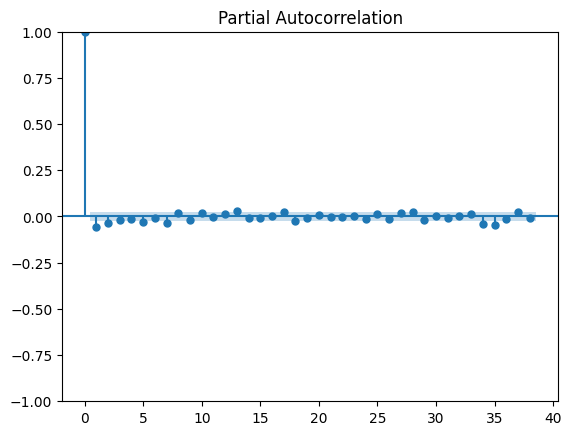

In [25]:
plt = plot_pacf(diff_series1['spx'])
plt.show()

* P=5 after the first differencing
* max lags we may need is 5

# ARIMA

In [26]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
p_values = range(1, 6)  
d_values = [1]         
q_values = range(1, 5) 

In [28]:
best_aic = float("inf")
best_bic = float("inf")
best_order = None
results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = ARIMA(series, order=order)
                model_fit = model.fit()
                aic = model_fit.aic
                bic = model_fit.bic
                
                results.append({
                    'order': order,
                    'AIC': aic,
                    'BIC': bic
                })

                if aic < best_aic:
                    best_aic = aic
                    best_order = order

            except Exception as e:
                continue # Skip models that fail to converge

results_df = pd.DataFrame(results).sort_values(by='AIC').reset_index(drop=True)

print("--- ARIMA Model Selection Results ---")
print(f"Total models tested: {len(results_df)}")
print("\nTop 5 Models by AIC:")
print(results_df.head())

print(f"\nModel with the lowest AIC (Optimal Fit): ARIMA{best_order}")
print(f"Best AIC Score: {best_aic:.4f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--- ARIMA Model Selection Results ---
Total models tested: 20

Top 5 Models by AIC:
       order           AIC           BIC
0  (5, 1, 4)  50503.839441  50571.284323
1  (1, 1, 1)  50505.357350  50525.590814
2  (2, 1, 1)  50507.090523  50534.068475
3  (1, 1, 2)  50507.091493  50534.069445
4  (5, 1, 2)  50507.426183  50561.382088

Model with the lowest AIC (Optimal Fit): ARIMA(5, 1, 4)
Best AIC Score: 50503.8394
